In [2]:
import sys
!conda install --yes --prefix {sys.prefix} pandasql

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pandasql


The following NEW packages will be INSTALLED:

  pandasql           conda-forge/noarch::pandasql-0.7.3-pyhd8ed1ab_0

The following packages will be UPDATED:

  ca-certificates                      2021.5.30-ha878542_0 --> 2021.10.8-ha878542_0
  certifi                          2021.5.30-py39hf3d152e_0 --> 2021.10.8-py39hf3d152e_1
  openssl                                 1.1.1k-h7f98852_1 --> 1.1.1l-h7f98852_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [3]:
import pandas as p
from pandasql import sqldf
from sklearn.model_selection import train_test_split
pysqldf = lambda q: sqldf(q, globals())

In [4]:
df_people = p.read_csv('../data/People.csv')
df_salaries = p.read_csv('../data/Salaries.csv')
df_appearances = p.read_csv('../data/Appearances.csv')
df_batting = p.read_csv('../data/Batting.csv')
df_fielding = p.read_csv('../data/Fielding.csv')

In [5]:
def display_stats(df, columnLabel, inc = 1, rnd = 0):
    numObj, minValue, maxValue, mean, stdev, Q1, median, Q3, IQR = [0,"inf","-inf",0,0,0,0,0,0]
    
    numObj = len(df)
    minValue = df[columnLabel].min()
    maxValue = df[columnLabel].max()
    mean = df[columnLabel].mean()
    stdev = df[columnLabel].std()
    Q1 = df[columnLabel].quantile(.25)
    median = df[columnLabel].median()
    Q3 = df[columnLabel].quantile(.75)
    IQR = Q3 - Q1
    
    print(f"""
      Min Value: {minValue}
      Max Value: {maxValue}
      Mean: {mean}
      Median: {median}
      Standard Deviation: {stdev}
      Q1: {Q1}
      Q3: {Q3}
      IQR: {IQR}
      ---
      Poorest: {minValue} - {max(0, Q1 - (1.5 * IQR))}
      Poor: {max(0, Q1 - (1.5 * IQR) + inc)} - {Q1}
      Fair: {Q1 + inc} - {median}
      Good: {median + inc} - {Q3}
      Great: {Q3 + inc} - {min(maxValue, Q3 + (1.5 * IQR))}
      Excellent: {min(maxValue, Q3 + (1.5 * IQR))} - {maxValue}
    """)

    return numObj, minValue, maxValue, mean, stdev, Q1, median, Q3, IQR

In [47]:
df_playerids = pysqldf("SELECT DISTINCT playerID from df_people group by playerID")
df_playerids.head(5)

batting_stats = pysqldf("""
    SELECT playerID, yearID, G, H / (AB - BB - SF) as BattingAverage, AB, R, H, HR, RBI, BB, SF 
    FROM df_batting 
    WHERE G >= 50 and AB > 0 and yearID > 1955
""")

player_salaries = pysqldf("""
    SELECT stats.playerID, stats.yearID, df_salaries.salary,
        next.salary as 'NextSalary',
        (next.salary - df_salaries.salary * 1.0) / ABS(df_salaries.salary) as Difference,
        G, BattingAverage, AB, R, H, HR, RBI, BB, SF
    FROM batting_stats as stats
    INNER JOIN df_salaries ON df_salaries.playerID = stats.playerID AND df_salaries.yearID = stats.yearID
    INNER JOIN (
        SELECT salary, playerID, yearID
        FROM df_salaries as next
    ) next ON df_salaries.playerID = next.playerID WHERE (df_salaries.yearID + 1) = next.yearID
""")

# player_salaries[ player_salaries['playerID'] == 'aguaylu01'].head(5)

fielders = pysqldf("""
    SELECT DISTINCT ps.playerID, ps.yearID, salary, NextSalary, Difference, POS, ps.G, BattingAverage, AB, R, H, HR, RBI, BB, SF, (PO + A) / (PO + A + E) as FieldingPercentage, A, E, PO
    FROM player_salaries AS ps
    INNER JOIN df_fielding ON ps.playerID=df_fielding.playerID AND ps.yearID=df_fielding.yearID
""")

# # fielders.head(5)

dataset = fielders.groupby(['playerID', 'yearID']).agg({
    'G': ['first'],
    'AB': ['first'],
    'H': ['first'],
    'HR': ['first'],
    'RBI': ['first'],
    'BB': ['first'],
    'SF': ['first'],
    'A': ['sum'],
    'E': ['sum'],
    'PO': ['sum'],
    'salary': ['first'],
    'NextSalary': ['first'],
    'Difference': ['first'],
}).reset_index()
dataset['FieldingPercentage'] = (dataset['A'] + dataset['PO']) / (dataset['PO'] + dataset['A'] + dataset['E'])
dataset['BattingAverage'] = dataset['H'] / (dataset['AB'] - dataset['BB'] - dataset['SF'])
dataset.columns = dataset.columns.droplevel(1)

dataset = dataset[dataset['G'] > 50]
dataset = dataset[dataset['AB'] > 500]


      Min Value: 0
      Max Value: 70
      Mean: 19.9209705372617
      Median: 19.0
      Standard Deviation: 11.41066095910969
      Q1: 11.0
      Q3: 27.0
      IQR: 16.0
      ---
      Poorest: 0 - 0
      Poor: 0 - 11.0
      Fair: 12.0 - 19.0
      Good: 20.0 - 27.0
      Great: 28.0 - 51.0
      Excellent: 51.0 - 70
    


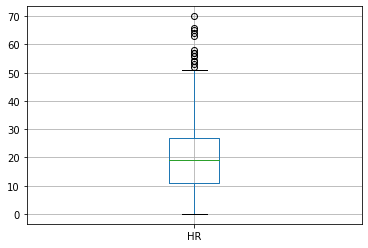

In [89]:
dataset['HR_Cat'] = p.cut(dataset['HR'], bins=[-1, 1, 3, 9, 17, 36, 100], labels=["Poorest", "Poor", "Fair", "Good", "Great", "Excellent"])
dataset['HR_Cat_Small'] = p.cut(dataset['HR'], bins=[-1, 9, 36, 100], labels=["Poor", "Good", "Excellent"])
display_stats(dataset, 'HR')
hr_axes = dataset.boxplot(column=['HR'], return_type='axes')


      Min Value: 17.0
      Max Value: 165.0
      Mean: 81.10398613518197
      Median: 80.0
      Standard Deviation: 24.6396273478094
      Q1: 62.0
      Q3: 99.0
      IQR: 37.0
      ---
      Poorest: 17.0 - 6.5
      Poor: 7.5 - 62.0
      Fair: 63.0 - 80.0
      Good: 81.0 - 99.0
      Great: 100.0 - 154.5
      Excellent: 154.5 - 165.0
    


<AxesSubplot:>

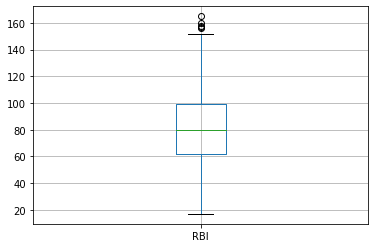

In [50]:
dataset['RBI_Cat'] = p.cut(dataset['RBI'], bins=[0, 1, 24, 44, 69, 135, 200], labels=["Poorest", "Poor", "Fair", "Good", "Great", "Excellent"])
dataset['RBI_Cat_Small'] = p.cut(dataset['RBI'], bins=[0, 44, 135, 200], labels=["Poor", "Good", "Excellent"])
display_stats(dataset, 'RBI')
dataset.boxplot(column=['RBI'], return_type='axes')


      Min Value: 0.21933085501858737
      Max Value: 0.47345132743362833
      Mean: 0.318905820702343
      Median: 0.315450643776824
      Standard Deviation: 0.03670018081733653
      Q1: 0.2938053097345133
      Q3: 0.33941605839416056
      IQR: 0.04561074865964726
      ---
      Poorest: 0.21933085501858737 - 0.2253891867450424
      Poor: 0.2263891867450424 - 0.2938053097345133
      Fair: 0.2948053097345133 - 0.315450643776824
      Good: 0.316450643776824 - 0.33941605839416056
      Great: 0.34041605839416056 - 0.4078321813836314
      Excellent: 0.4078321813836314 - 0.47345132743362833
    


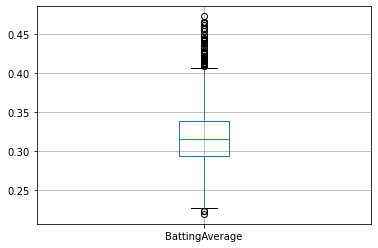

In [51]:
dataset['BA_Cat'] = p.cut(dataset['BattingAverage'], bins=[0.0, 0.177, 0.266, 0.296, 0.325, 0.412, 0.5], labels=["Poorest", "Poor", "Fair", "Good", "Great", "Excellent"], precision=3)
dataset['BA_Cat_Small'] = p.cut(dataset['BattingAverage'], bins=[0.0, 0.177, 0.296, 0.5], labels=["Poor", "Good", "Excellent"], precision=3)
display_stats(dataset, 'BattingAverage', 0.001, 3)
ba_axes = dataset.boxplot(column=['BattingAverage'], return_type='axes')


      Min Value: 0.8333333333333334
      Max Value: 1.0
      Mean: 0.9811913373709764
      Median: 0.9847050173781303
      Standard Deviation: 0.014213560158615366
      Q1: 0.9741507849454994
      Q3: 0.9916695561719834
      IQR: 0.01751877122648393
      ---
      Poorest: 0.8333333333333334 - 0.9478726281057736
      Poor: 0.9488726281057736 - 0.9741507849454994
      Fair: 0.9751507849454994 - 0.9847050173781303
      Good: 0.9857050173781303 - 0.9916695561719834
      Great: 0.9926695561719834 - 1.0
      Excellent: 1.0 - 1.0
    


(0.9, 1.0)

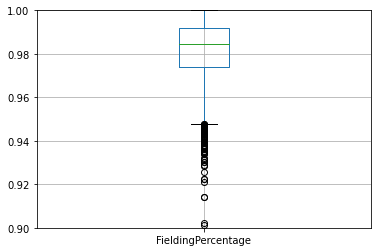

In [52]:
dataset['FP_Cat'] = p.cut(dataset['FieldingPercentage'], bins=[0, 0.5, 0.942, 0.973, 0.986, 0.993, 1], labels=["Poorest", "Poor", "Fair", "Good", "Great", "Excellent"], precision=3)
dataset['FP_Cat_Small'] = p.cut(dataset['FieldingPercentage'], bins=[0, 0.942, 0.993, 1], labels=["Poor", "Good", "Excellent"], precision=3)
display_stats(dataset, 'FieldingPercentage', 0.001, 3)
fp_axes = dataset.boxplot(column=['FieldingPercentage'], return_type='axes')
fp_axes.set_ylim(0.9, 1)


      Min Value: -0.9705405405405405
      Max Value: 14.677966101694915
      Mean: 0.8927998354482094
      Median: 0.32142857142857145
      Standard Deviation: 1.675305507190177
      Q1: 0.055487053020961775
      Q3: 0.8848167539267016
      IQR: 0.8293297009057398
      ---
      Poorest: -0.9705405405405405 - 0
      Poor: 0 - 0.055487053020961775
      Fair: 0.056487053020961776 - 0.32142857142857145
      Good: 0.32242857142857145 - 0.8848167539267016
      Great: 0.8858167539267016 - 2.1288113052853115
      Excellent: 2.1288113052853115 - 14.677966101694915
    


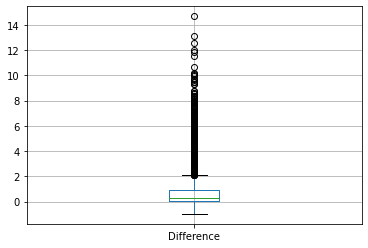

In [98]:
dataset['Salary_Increase'] = p.cut(dataset['Difference'], bins=[-1.0, 0, 0.032, 0.251, 0.693, 1, 15], labels=["Poorest", "Poor", "Fair", "Good", "Great", "Excellent"], precision=3)
dataset['Salary_Increase_Small'] = p.cut(dataset['Difference'], bins=[0, 1, 15], labels=["Small", "Large"], precision=3)
display_stats(dataset, 'Difference', 0.001)
diff_axes = dataset.boxplot(column=['Difference'], return_type='axes')

dataset['HighestSalary'] = dataset.groupby(['playerID'])['salary'].transform('max')
dataset['LowestSalary'] = dataset.groupby(['playerID'])['salary'].transform('min')

In [99]:
# Reference: 
# https://deebuls.github.io/Naive-Bayes-Pandas.html
# 
def get_prior(df, attr):
    return df.groupby(attr).size().div(len(df))

print('Probabilities with many Categories \n')
probabilities = {}
# probabilities['Salary_Increase'] = get_prior(dataset, 'Salary_Increase')
probabilities['HR'] = get_prior(dataset, ['Salary_Increase', 'HR_Cat'])
probabilities['RBI'] = get_prior(dataset, ['Salary_Increase', 'RBI_Cat'])
probabilities['Batting_Average'] = get_prior(dataset, ['Salary_Increase', 'BA_Cat'])
probabilities['Fielding_Percentage'] = get_prior(dataset, ['Salary_Increase', 'FP_Cat'])

print(probabilities)
print('\n\n')

print('Probabilities with fewer Categories \n')
probabilities_small = {}
probabilities_small['HR'] = get_prior(dataset, ['Salary_Increase_Small', 'HR_Cat_Small', 'RBI_Cat_Small'])
probabilities_small['RBI'] = get_prior(dataset, ['Salary_Increase_Small', 'RBI_Cat_Small'])
probabilities_small['Batting_Average'] = get_prior(dataset, ['Salary_Increase_Small', 'BA_Cat_Small'])
probabilities_small['Fielding_Percentage'] = get_prior(dataset, ['Salary_Increase_Small', 'FP_Cat_Small'])
print(probabilities_small)

Probabilities with many Categories 

{'HR': Salary_Increase  HR_Cat   
Poorest          Poorest      0.002773
                 Poor         0.007626
                 Fair         0.028423
                 Good         0.044714
                 Great        0.082842
                 Excellent    0.017678
Poor             Poorest      0.000347
                 Poor         0.000347
                 Fair         0.003466
                 Good         0.007279
                 Great        0.008666
                 Excellent    0.003120
Fair             Poorest      0.007972
                 Poor         0.008319
                 Fair         0.035355
                 Good         0.064818
                 Great        0.110572
                 Excellent    0.024957
Good             Poorest      0.003466
                 Poor         0.007626
                 Fair         0.036395
                 Good         0.059965
                 Great        0.108492
                 Excellent    0.

In [97]:
def check_salary_dip(df, threshhold = 1, total = 50):
    id = ''
    hash = ''
    tuples = {}
    for index, row in df.iterrows():
        current_id = row['playerID']

        if (len(tuples.items()) > total):
            print(len(tuples.items()), total)
            break;
        
        # Next row does not continue the same player 
        if (id and current_id != id):
            id = ''
            hash = ''
            
        if (current_id == id):
            tuples[f'{current_id}-{hash}']['second'] = row[['Salary_Increase_Small', 'BA_Cat', 'BA_Cat_Small', 'FP_Cat', 'FP_Cat_Small', 'HR_Cat', 'HR_Cat_Small', 'RBI_Cat', 'RBI_Cat_Small']]
            id = ''
            hash = ''
        
        if (row['Difference'] >= threshhold):
            id = current_id
            hash = index
            tuples[f'{current_id}-{hash}'] = {}
            tuples[f'{current_id}-{hash}']['first'] = row[['Salary_Increase_Small', 'BA_Cat', 'BA_Cat_Small', 'FP_Cat', 'FP_Cat_Small', 'HR_Cat', 'HR_Cat_Small', 'RBI_Cat', 'RBI_Cat_Small']]
    
    return tuples

regular_rating = {
    "Poorest": 5, "Poor": 4, "Fair": 3, "Good": 2, "Great": 1, "Excellent": 0
}

small_rating = {
    "Poor": 2, "Good": 1, "Excellent": 0
}

def check_probabilities(tuples, column, rating_system, rating = -2):
    total = 0
    for id, value in tuples.items():
        first_rating = rating_system[value['first'][column]]
        if ('second' in value.keys()):
            second_rating = rating_system[value['second'][column]]
            if (first_rating - second_rating <= rating):
                total += 1
    
    return total / len(tuples)

# dataset.head(5)
tuples = check_salary_dip(dataset.sort_values(by=['playerID', 'yearID']), 1, 800)
rbi_prob_small = check_probabilities(tuples, 'RBI_Cat_Small', small_rating, -1)
hr_prob_small = check_probabilities(tuples, 'HR_Cat_Small', small_rating, -1)
ba_prob_small = check_probabilities(tuples, 'BA_Cat_Small', small_rating, -1)
fp_prob_small = check_probabilities(tuples, 'FP_Cat_Small', small_rating, -1)

print('Probability with small (RBI)', rbi_prob_small)
print('Probability with small (HR)', hr_prob_small)
print('Probability with small (Batting Average)', ba_prob_small)
print('Probability with small (Fielding Percentage)', fp_prob_small)

rbi_prob = check_probabilities(tuples, 'RBI_Cat', regular_rating, -1)
hr_prob = check_probabilities(tuples, 'HR_Cat', regular_rating, -1)
ba_prob = check_probabilities(tuples, 'BA_Cat', regular_rating, -1)
fp_prob = check_probabilities(tuples, 'FP_Cat', regular_rating, -1)

print('Probability (RBI)', rbi_prob)
print('Probability (HR)', hr_prob)
print('Probability (Batting Average)', ba_prob)
print('Probability (Fielding Percentage)', fp_prob)

Probability with small (RBI) 0.0364741641337386
Probability with small (HR) 0.07598784194528875
Probability with small (Batting Average) 0.13829787234042554
Probability with small (Fielding Percentage) 0.08206686930091185
Probability (RBI) 0.11398176291793313
Probability (HR) 0.18693009118541035
Probability (Batting Average) 0.2750759878419453
Probability (Fielding Percentage) 0.19148936170212766
